<a href="https://colab.research.google.com/github/afroditinats/PINNs/blob/main/h_t_parameter_error.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 17.3 MB/s eta 0:00:00


In [3]:
import optuna
import torch
import numpy as np
import time
import joblib
import pandas as pd
import os
from modules import Model
from data import get_data
from pinn import PINN_experiment
os.environ["TORCHDYNAMO_DISABLE"] = "1"
optimizers = {"AdamW": torch.optim.AdamW,"SGD": torch.optim.SGD,"LBFGS": torch.optim.LBFGS,}

def modify_network(layers, neurons):
    activation = torch.nn.Tanh
    network = [torch.nn.Linear(2, neurons).double(), activation().double()]
    for _ in range(layers - 2):
        network.append(torch.nn.Linear(neurons, neurons).double())
        network.append(activation().double())
    network.append(torch.nn.Linear(neurons, 1).double())
    return torch.nn.Sequential(*network)

def objective(trial):
    layers = trial.suggest_int("layers", 3, 50)
    neurons = trial.suggest_int("neurons", 5, 50)
    optimizer_name = trial.suggest_categorical("optimizer", list(optimizers.keys()))
    iterations = trial.suggest_int("iterations", 1000, 10000)

    viscosity = -1.0 #initial
    optimizer = optimizers[optimizer_name]

    Model.create_network = lambda self: modify_network(layers, neurons) #standard nn we use
    model = Model()
    model.adam_optimizer = torch.optim.AdamW(model.network.parameters())
    model.visc = torch.nn.Parameter(torch.tensor([viscosity], dtype=torch.double))
    model.network.register_parameter("visc", model.visc)
    model.lbfgs_optimizer = optimizer(model.network.parameters())

    data = get_data()
    start_time = time.time()
    PINN_experiment(data, [0.0], verbose=False, rerun=True)
    all_results = np.load("./results/pinn_results.npy", allow_pickle=True)
    rmse = all_results[0][-1]
    estimated_viscosity = all_results[1][-1]
    param_error = all_results[2][-1]
    run_time = time.time() - start_time
    trial.set_user_attr("RMSE", rmse)
    trial.set_user_attr("Estimated Viscosity", estimated_viscosity)
    trial.set_user_attr("Parameter Error", param_error)
    trial.set_user_attr("Runtime", run_time)
    print(f"[ParamError] RMSE={rmse}, Viscosity={estimated_viscosity}, Param Error={param_error}, Time={run_time:.2f}s")
    return param_error

study = optuna.create_study(direction="minimize")  #minimize ==> i want to find the lowest param errors
study.optimize(objective, n_trials=50, n_jobs=4) #trials=50 (takes 1 day to finish while parallel coding /n_jobs=4)
joblib.dump(study, "optuna_param_error.pkl")

df = pd.DataFrame([
    {"Parameter Error": t.user_attrs.get("Parameter Error"), "RMSE": t.user_attrs.get("RMSE"), "Estimated Viscosity": t.user_attrs.get("Estimated Viscosity"),"Runtime (s)": t.user_attrs.get("Runtime"), "Layers": t.params["layers"],"Neurons": t.params["neurons"],"Optimizer": t.params["optimizer"],"Iterations": t.params["iterations"]}
    for t in study.trials
])
df.to_csv("optuna_param_error_results.csv", index=False)
print("Saved Parameter Error study and results.")


[I 2025-03-23 23:09:00,153] A new study created in memory with name: no-name-90aecd2d-98e4-4021-b174-63619bcb124a


Loaded data.
Loaded data.
Loaded data.
Loaded data.


[I 2025-03-24 00:23:04,760] Trial 3 finished with value: 4.6274631884744494e-09 and parameters: {'layers': 14, 'neurons': 35, 'optimizer': 'SGD', 'iterations': 7000}. Best is trial 3 with value: 4.6274631884744494e-09.


PINN test complete.
[ParamError] RMSE=3.659834628252739e-05, Viscosity=0.003115073401982979, Param Error=4.6274631884744494e-09, Time=4443.76s
Loaded data.


[I 2025-03-24 00:23:20,970] Trial 0 finished with value: 1.0616905673291544e-08 and parameters: {'layers': 40, 'neurons': 16, 'optimizer': 'LBFGS', 'iterations': 9898}. Best is trial 3 with value: 4.6274631884744494e-09.


PINN test complete.
[ParamError] RMSE=3.937325706003887e-05, Viscosity=0.0030800604919299377, Param Error=1.0616905673291544e-08, Time=4460.01s
Loaded data.


[I 2025-03-24 00:23:27,588] Trial 2 finished with value: 8.671760601124216e-09 and parameters: {'layers': 28, 'neurons': 22, 'optimizer': 'AdamW', 'iterations': 2982}. Best is trial 3 with value: 4.6274631884744494e-09.


PINN test complete.
[ParamError] RMSE=3.5143022706017614e-05, Viscosity=0.0030899765734149725, Param Error=8.671760601124216e-09, Time=4466.19s
Loaded data.


[I 2025-03-24 00:24:48,961] Trial 1 finished with value: 1.7544916841170439e-07 and parameters: {'layers': 16, 'neurons': 35, 'optimizer': 'SGD', 'iterations': 1927}. Best is trial 3 with value: 4.6274631884744494e-09.


PINN test complete.
[ParamError] RMSE=0.0001344083412088059, Viscosity=0.003601965389996585, Param Error=1.7544916841170439e-07, Time=4548.18s
Loaded data.


[I 2025-03-24 00:57:28,435] Trial 7 finished with value: 4.081308234604021e-06 and parameters: {'layers': 21, 'neurons': 10, 'optimizer': 'AdamW', 'iterations': 2228}. Best is trial 3 with value: 4.6274631884744494e-09.


PINN test complete.
[ParamError] RMSE=0.006037159692341492, Viscosity=0.0011628740638008122, Param Error=4.081308234604021e-06, Time=1958.61s
Loaded data.


[I 2025-03-24 00:59:15,702] Trial 0 finished with value: 3.367263288857497e-11 and parameters: {'layers': 13, 'neurons': 19, 'optimizer': 'SGD', 'iterations': 1276}. Best is trial 0 with value: 3.367263288857497e-11.


PINN test complete.
[ParamError] RMSE=4.4966424236441356e-05, Viscosity=0.0031889016743360476, Param Error=3.367263288857497e-11, Time=6656.69s


[I 2025-03-24 01:03:20,377] Trial 1 finished with value: 1.955637722947797e-09 and parameters: {'layers': 16, 'neurons': 48, 'optimizer': 'SGD', 'iterations': 9519}. Best is trial 0 with value: 3.367263288857497e-11.


PINN test complete.
[ParamError] RMSE=4.362206013026375e-05, Viscosity=0.0031388762689362262, Param Error=1.955637722947797e-09, Time=6901.47s


[I 2025-03-24 01:03:34,067] Trial 8 finished with value: 1.8681147556411642e-07 and parameters: {'layers': 4, 'neurons': 12, 'optimizer': 'AdamW', 'iterations': 8998}. Best is trial 3 with value: 4.6274631884744494e-09.


PINN test complete.
[ParamError] RMSE=6.064376528653186e-05, Viscosity=0.00361531579297795, Param Error=1.8681147556411642e-07, Time=364.76s
Loaded data.


[I 2025-03-24 01:11:57,086] Trial 6 finished with value: 0.01029996801627602 and parameters: {'layers': 40, 'neurons': 18, 'optimizer': 'LBFGS', 'iterations': 8640}. Best is trial 3 with value: 4.6274631884744494e-09.


PINN test complete.
[ParamError] RMSE=0.37746393853854426, Viscosity=0.10467185694013946, Param Error=0.01029996801627602, Time=2908.74s
Loaded data.


[I 2025-03-24 01:27:34,588] Trial 4 finished with value: 5.29839592939418e-10 and parameters: {'layers': 12, 'neurons': 42, 'optimizer': 'AdamW', 'iterations': 4048}. Best is trial 4 with value: 5.29839592939418e-10.


PINN test complete.
[ParamError] RMSE=6.33144476530466e-05, Viscosity=0.003160080617053836, Param Error=5.29839592939418e-10, Time=3868.88s
Loaded data.


[I 2025-03-24 01:43:23,496] Trial 5 finished with value: 8.749676830640965e-07 and parameters: {'layers': 37, 'neurons': 17, 'optimizer': 'AdamW', 'iterations': 2283}. Best is trial 4 with value: 5.29839592939418e-10.


PINN test complete.
[ParamError] RMSE=0.004497642315860334, Viscosity=0.0022477017894327726, Param Error=8.749676830640965e-07, Time=4801.82s
Loaded data.


[I 2025-03-24 02:56:29,830] Trial 10 finished with value: 0.008329505360127349 and parameters: {'layers': 37, 'neurons': 42, 'optimizer': 'SGD', 'iterations': 2836}. Best is trial 4 with value: 5.29839592939418e-10.


PINN test complete.
[ParamError] RMSE=0.37746393955799135, Viscosity=0.09444922269827213, Param Error=0.008329505360127349, Time=6272.00s
Loaded data.


[I 2025-03-24 02:57:48,389] Trial 11 finished with value: 0.01029996801627602 and parameters: {'layers': 41, 'neurons': 43, 'optimizer': 'SGD', 'iterations': 7466}. Best is trial 4 with value: 5.29839592939418e-10.


PINN test complete.
[ParamError] RMSE=0.37746393853472476, Viscosity=0.10467185694013946, Param Error=0.01029996801627602, Time=5413.50s
Loaded data.


[I 2025-03-24 03:08:30,752] Trial 13 finished with value: 1.1115812578969887e-05 and parameters: {'layers': 3, 'neurons': 49, 'optimizer': 'AdamW', 'iterations': 4884}. Best is trial 4 with value: 5.29839592939418e-10.


PINN test complete.
[ParamError] RMSE=0.0009646033263267319, Viscosity=0.0065171373407655105, Param Error=1.1115812578969887e-05, Time=720.04s
Loaded data.


[I 2025-03-24 03:16:06,943] Trial 14 finished with value: 6.304759686443262e-09 and parameters: {'layers': 7, 'neurons': 32, 'optimizer': 'SGD', 'iterations': 5470}. Best is trial 4 with value: 5.29839592939418e-10.


PINN test complete.
[ParamError] RMSE=4.263971113493462e-05, Viscosity=0.003103696344960649, Param Error=6.304759686443262e-09, Time=1098.01s
Loaded data.


[I 2025-03-24 03:25:46,225] Trial 9 finished with value: 2.703572802260244e-12 and parameters: {'layers': 28, 'neurons': 47, 'optimizer': 'LBFGS', 'iterations': 2637}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=5.546465642951103e-05, Viscosity=0.003184743116320115, Param Error=2.703572802260244e-12, Time=8531.73s
Loaded data.


[I 2025-03-24 03:50:40,102] Trial 15 finished with value: 1.1076645178290256e-08 and parameters: {'layers': 13, 'neurons': 31, 'optimizer': 'SGD', 'iterations': 5615}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=4.092079396776965e-05, Viscosity=0.0032883445039248375, Param Error=1.1076645178290256e-08, Time=2528.91s
Loaded data.


[I 2025-03-24 03:53:56,954] Trial 12 finished with value: 0.01029996801627602 and parameters: {'layers': 48, 'neurons': 47, 'optimizer': 'SGD', 'iterations': 2813}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=0.37746393853843463, Viscosity=0.10467185694013946, Param Error=0.01029996801627602, Time=7832.60s
Loaded data.


[I 2025-03-24 03:58:31,644] Trial 16 finished with value: 1.378220561584496e-08 and parameters: {'layers': 13, 'neurons': 36, 'optimizer': 'SGD', 'iterations': 7073}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=4.596085827045697e-05, Viscosity=0.0030657012229526, Param Error=1.378220561584496e-08, Time=2543.97s
Loaded data.


[I 2025-03-24 05:47:28,818] Trial 20 finished with value: 1.52433380658134e-08 and parameters: {'layers': 26, 'neurons': 42, 'optimizer': 'LBFGS', 'iterations': 4066}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=5.657871766436499e-05, Viscosity=0.0030596349478151717, Param Error=1.52433380658134e-08, Time=6536.55s
Loaded data.


[I 2025-03-24 06:05:35,202] Trial 17 finished with value: 1.7950394868015408e-09 and parameters: {'layers': 29, 'neurons': 50, 'optimizer': 'LBFGS', 'iterations': 4155}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=4.639161820016837e-05, Viscosity=0.0031407309555077432, Param Error=1.7950394868015408e-09, Time=9588.49s
Loaded data.


[I 2025-03-24 06:08:51,884] Trial 19 finished with value: 4.233300220942929e-06 and parameters: {'layers': 28, 'neurons': 42, 'optimizer': 'LBFGS', 'iterations': 3907}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=0.005342413649132722, Viscosity=0.0011256003269798796, Param Error=4.233300220942929e-06, Time=8094.27s
Loaded data.


[I 2025-03-24 06:25:55,050] Trial 23 finished with value: 0.00012403469523756326 and parameters: {'layers': 22, 'neurons': 5, 'optimizer': 'LBFGS', 'iterations': 1679}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=0.019095823004437306, Viscosity=0.014320185340695978, Param Error=0.00012403469523756326, Time=1022.62s
Loaded data.


[I 2025-03-24 06:45:08,938] Trial 18 finished with value: 2.211035885662e-06 and parameters: {'layers': 29, 'neurons': 50, 'optimizer': 'LBFGS', 'iterations': 3872}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=0.005276180191806895, Viscosity=0.001696143621872023, Param Error=2.211035885662e-06, Time=10467.92s
Loaded data.


[I 2025-03-24 06:59:16,609] Trial 22 finished with value: 5.5829478338641284e-09 and parameters: {'layers': 22, 'neurons': 26, 'optimizer': 'LBFGS', 'iterations': 3813}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=5.8322436398914226e-05, Viscosity=0.0032578179881300696, Param Error=5.5829478338641284e-09, Time=3221.10s
Loaded data.


[I 2025-03-24 08:30:59,716] Trial 21 finished with value: 2.0575959241241975e-06 and parameters: {'layers': 29, 'neurons': 50, 'optimizer': 'LBFGS', 'iterations': 1244}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=0.0034920295074055254, Viscosity=0.0017486665964017878, Param Error=2.0575959241241975e-06, Time=9809.04s
Loaded data.


[I 2025-03-24 09:48:29,954] Trial 24 finished with value: 4.658273699792024e-07 and parameters: {'layers': 32, 'neurons': 50, 'optimizer': 'LBFGS', 'iterations': 1103}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=0.0001902373563213296, Viscosity=0.0038656143341747637, Param Error=4.658273699792024e-07, Time=12154.32s
Loaded data.


[I 2025-03-24 09:53:54,611] Trial 26 finished with value: 2.208524355886236e-06 and parameters: {'layers': 34, 'neurons': 46, 'optimizer': 'LBFGS', 'iterations': 1021}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=0.003076081832723975, Viscosity=0.001696988382806743, Param Error=2.208524355886236e-06, Time=10477.31s
Loaded data.


[I 2025-03-24 09:54:33,562] Trial 25 finished with value: 7.986205390628863e-09 and parameters: {'layers': 34, 'neurons': 46, 'optimizer': 'LBFGS', 'iterations': 4703}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=0.00015067957519139278, Viscosity=0.003272464433456002, Param Error=7.986205390628863e-09, Time=11363.57s
Loaded data.


[I 2025-03-24 11:01:05,225] Trial 29 finished with value: 1.207178321951724e-10 and parameters: {'layers': 17, 'neurons': 39, 'optimizer': 'AdamW', 'iterations': 4888}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=6.197089070218955e-05, Viscosity=0.00319408602854253, Param Error=1.207178321951724e-10, Time=4029.97s
Loaded data.


[I 2025-03-24 11:13:54,500] Trial 30 finished with value: 3.7841096832573445e-09 and parameters: {'layers': 19, 'neurons': 40, 'optimizer': 'AdamW', 'iterations': 6039}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=6.83918552706657e-05, Viscosity=0.0031215837443198747, Param Error=3.7841096832573445e-09, Time=4760.08s
Loaded data.


[I 2025-03-24 11:16:18,296] Trial 27 finished with value: 3.319188825014516e-08 and parameters: {'layers': 33, 'neurons': 45, 'optimizer': 'AdamW', 'iterations': 4484}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=4.299336741766336e-05, Viscosity=0.003365285272555461, Param Error=3.319188825014516e-08, Time=9917.88s
Loaded data.


[I 2025-03-24 11:22:45,363] Trial 28 finished with value: 8.844134689300757e-09 and parameters: {'layers': 18, 'neurons': 45, 'optimizer': 'AdamW', 'iterations': 4930}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=3.9221035176166656e-05, Viscosity=0.003089055602168217, Param Error=8.844134689300757e-09, Time=5654.72s
Loaded data.


[I 2025-03-24 11:33:48,674] Trial 31 finished with value: 2.435085145728222e-09 and parameters: {'layers': 9, 'neurons': 38, 'optimizer': 'AdamW', 'iterations': 6280}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=4.166618362707579e-05, Viscosity=0.003133752279932691, Param Error=2.435085145728222e-09, Time=1962.83s
Loaded data.


[I 2025-03-24 11:45:58,944] Trial 32 finished with value: 3.1810746676667605e-10 and parameters: {'layers': 8, 'neurons': 38, 'optimizer': 'AdamW', 'iterations': 3318}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=3.2927684172068424e-05, Viscosity=0.003165263294373801, Param Error=3.1810746676667605e-10, Time=1923.76s
Loaded data.


[I 2025-03-24 11:47:36,134] Trial 33 finished with value: 8.153170011880638e-09 and parameters: {'layers': 9, 'neurons': 38, 'optimizer': 'AdamW', 'iterations': 6371}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=3.094037200056991e-05, Viscosity=0.0030928039560464914, Param Error=8.153170011880638e-09, Time=1877.32s
Loaded data.


[I 2025-03-24 12:22:28,928] Trial 36 finished with value: 5.254169609517753e-09 and parameters: {'layers': 9, 'neurons': 39, 'optimizer': 'AdamW', 'iterations': 3274}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=7.47347135075294e-05, Viscosity=0.00311061321077842, Param Error=5.254169609517753e-09, Time=2189.69s
Loaded data.


[I 2025-03-24 12:28:36,995] Trial 37 finished with value: 9.057274114343075e-10 and parameters: {'layers': 15, 'neurons': 30, 'optimizer': 'AdamW', 'iterations': 3181}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=6.29166660030483e-05, Viscosity=0.0031530035563662176, Param Error=9.057274114343075e-10, Time=2460.52s
Loaded data.


[I 2025-03-24 13:07:34,231] Trial 35 finished with value: 1.232990855388392e-08 and parameters: {'layers': 24, 'neurons': 39, 'optimizer': 'AdamW', 'iterations': 3231}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=5.576165190274207e-05, Viscosity=0.0032941389832079953, Param Error=1.232990855388392e-08, Time=5624.95s
Loaded data.


[I 2025-03-24 13:09:08,367] Trial 34 finished with value: 2.8256232131004165e-09 and parameters: {'layers': 25, 'neurons': 38, 'optimizer': 'AdamW', 'iterations': 3431}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=3.847945257392237e-05, Viscosity=0.003129942270401845, Param Error=2.8256232131004165e-09, Time=6382.51s
Loaded data.


[I 2025-03-24 13:12:32,374] Trial 38 finished with value: 2.1878602409425137e-08 and parameters: {'layers': 16, 'neurons': 32, 'optimizer': 'AdamW', 'iterations': 3361}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=7.085895830561914e-05, Viscosity=0.0033310130342806624, Param Error=2.1878602409425137e-08, Time=3002.62s
Loaded data.


[I 2025-03-24 13:43:12,376] Trial 40 finished with value: 8.350553152954898e-09 and parameters: {'layers': 11, 'neurons': 34, 'optimizer': 'AdamW', 'iterations': 2537}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=6.407606207477701e-05, Viscosity=0.003091717500757242, Param Error=8.350553152954898e-09, Time=2137.41s
Loaded data.


[I 2025-03-24 13:43:33,538] Trial 42 finished with value: 4.078790200228103e-09 and parameters: {'layers': 12, 'neurons': 25, 'optimizer': 'AdamW', 'iterations': 2608}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=4.312264327133061e-05, Viscosity=0.003119233454924398, Param Error=4.078790200228103e-09, Time=1860.83s
Loaded data.


[I 2025-03-24 13:51:38,708] Trial 39 finished with value: 2.7644232171989514e-08 and parameters: {'layers': 25, 'neurons': 34, 'optimizer': 'AdamW', 'iterations': 2514}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=5.674285202949632e-05, Viscosity=0.003016833314679184, Param Error=2.7644232171989514e-08, Time=4981.32s
Loaded data.


[I 2025-03-24 13:55:04,641] Trial 43 finished with value: 2.383584278615371e-10 and parameters: {'layers': 6, 'neurons': 23, 'optimizer': 'AdamW', 'iterations': 2008}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=3.6250112730738854e-05, Viscosity=0.0031985377228017716, Param Error=2.383584278615371e-10, Time=711.91s
Loaded data.


[I 2025-03-24 13:59:35,105] Trial 44 finished with value: 7.629553080918018e-11 and parameters: {'layers': 5, 'neurons': 34, 'optimizer': 'AdamW', 'iterations': 1842}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=5.756870216276866e-05, Viscosity=0.00319183359313367, Param Error=7.629553080918018e-11, Time=960.94s
Loaded data.


[I 2025-03-24 14:06:21,174] Trial 46 finished with value: 1.2710413259779812e-08 and parameters: {'layers': 6, 'neurons': 21, 'optimizer': 'AdamW', 'iterations': 2110}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=0.00010849593739427366, Viscosity=0.003295839330436276, Param Error=1.2710413259779812e-08, Time=675.61s
Loaded data.


[I 2025-03-24 14:11:14,010] Trial 47 finished with value: 1.0991950266762724e-09 and parameters: {'layers': 6, 'neurons': 20, 'optimizer': 'AdamW', 'iterations': 1528}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=5.473366864247303e-05, Viscosity=0.0031499447515847836, Param Error=1.0991950266762724e-09, Time=698.00s
Loaded data.


[I 2025-03-24 14:16:53,096] Trial 41 finished with value: 4.374381496906052e-10 and parameters: {'layers': 18, 'neurons': 35, 'optimizer': 'AdamW', 'iterations': 2270}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=4.710109231704548e-05, Viscosity=0.0032040138839438148, Param Error=4.374381496906052e-10, Time=4064.13s


[I 2025-03-24 14:17:44,228] Trial 49 finished with value: 5.66716046662975e-06 and parameters: {'layers': 3, 'neurons': 28, 'optimizer': 'AdamW', 'iterations': 1872}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=0.0005994678108062077, Viscosity=0.005563678721164149, Param Error=5.66716046662975e-06, Time=389.34s


[I 2025-03-24 14:17:55,529] Trial 48 finished with value: 5.439883587481541e-10 and parameters: {'layers': 5, 'neurons': 29, 'optimizer': 'AdamW', 'iterations': 1702}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=3.4252540237951376e-05, Viscosity=0.0031597753038171386, Param Error=5.439883587481541e-10, Time=694.14s


[I 2025-03-24 14:22:45,092] Trial 45 finished with value: 7.623307787754665e-08 and parameters: {'layers': 16, 'neurons': 30, 'optimizer': 'AdamW', 'iterations': 1988}. Best is trial 9 with value: 2.703572802260244e-12.


PINN test complete.
[ParamError] RMSE=0.0002440086207876654, Viscosity=0.0034592022444277382, Param Error=7.623307787754665e-08, Time=1866.05s
Saved Parameter Error study and results.


In [5]:
import optuna.visualization as vis
study = joblib.load("optuna_param_error.pkl")
vis.plot_param_importances(study)

In [27]:
display(top_df[["Parameter Error","RMSE","Layers","Neurons","Optimizer","Iterations", "Estimated Viscosity"]].round(12))

,Parameter Error,RMSE,Layers,Neurons,Optimizer,Iterations,Estimated Viscosity
0,3.000000e-12,0.000055,28,47,LBFGS,2637,0.003185
1,7.600000e-11,0.000058,5,34,AdamW,1842,0.003192
2,1.210000e-10,0.000062,17,39,AdamW,4888,0.003194
3,2.380000e-10,0.000036,6,23,AdamW,2008,0.003199
4,3.180000e-10,0.000033,8,38,AdamW,3318,0.003165
5,4.370000e-10,0.000047,18,35,AdamW,2270,0.003204
6,5.300000e-10,0.000063,12,42,AdamW,4048,0.003160
7,5.440000e-10,0.000034,5,29,AdamW,1702,0.003160
8,9.060000e-10,0.000063,15,30,AdamW,3181,0.003153
9,1.099000e-09,0.000055,6,20,AdamW,1528,0.003150


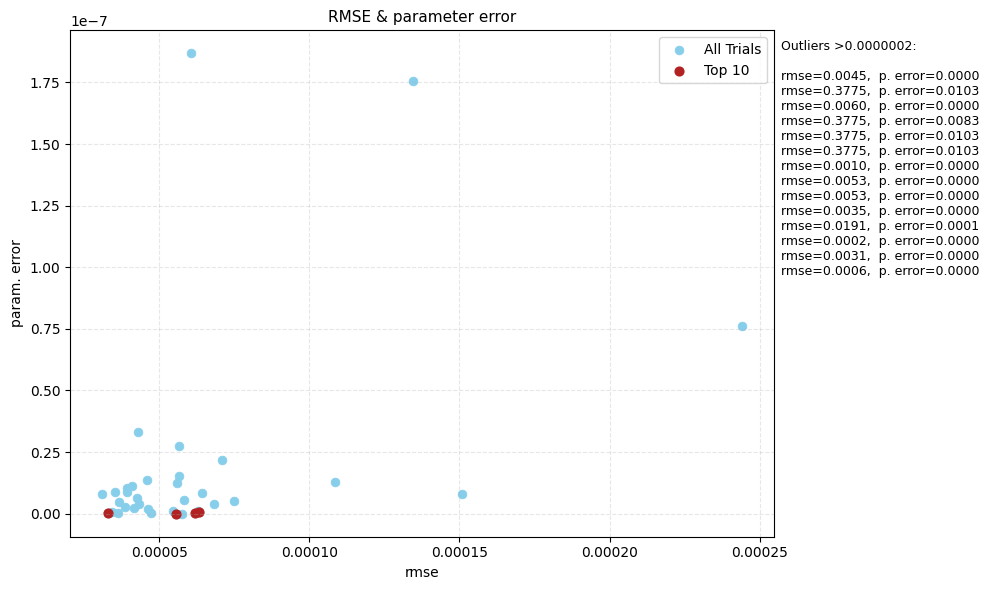

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
threshold = 0.0000002
inliers = df[df["Parameter Error"] <= threshold].reset_index(drop=True)
outliers = df[df["Parameter Error"] > threshold].reset_index()
top10_indices = df.nsmallest(10, "Parameter Error").index

plt.figure(figsize=(10, 6))
plt.scatter(inliers["RMSE"], inliers["Parameter Error"],
            color="skyblue", s=40,  label="All Trials", edgecolors='skyblue', linewidths=0.5)
for i in top10_indices:
    if i in inliers.index:
        plt.scatter(df.loc[i, "RMSE"], df.loc[i, "Parameter Error"],
                    color="firebrick", s=40, edgecolors='firebrick', label="Top 10" if i == top10_indices[0] else "")
if not outliers.empty:
    outlier_text = "Outliers >0.0000002:\n\n"
    for idx, row in outliers.iterrows():
        outlier_text += f"rmse={row['RMSE']:.4f},  p. error={row['Parameter Error']:.4f}\n"
    plt.gca().text(1.01, 0.98, outlier_text,
                   transform=plt.gca().transAxes,
                   fontsize=9, verticalalignment='top', color='black')

plt.xlabel("rmse", color='black')
plt.ylabel("param. error", color='black')
plt.title("RMSE & parameter error", fontsize=11)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

<ipython-input-104-c30d19fdac97>:43: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



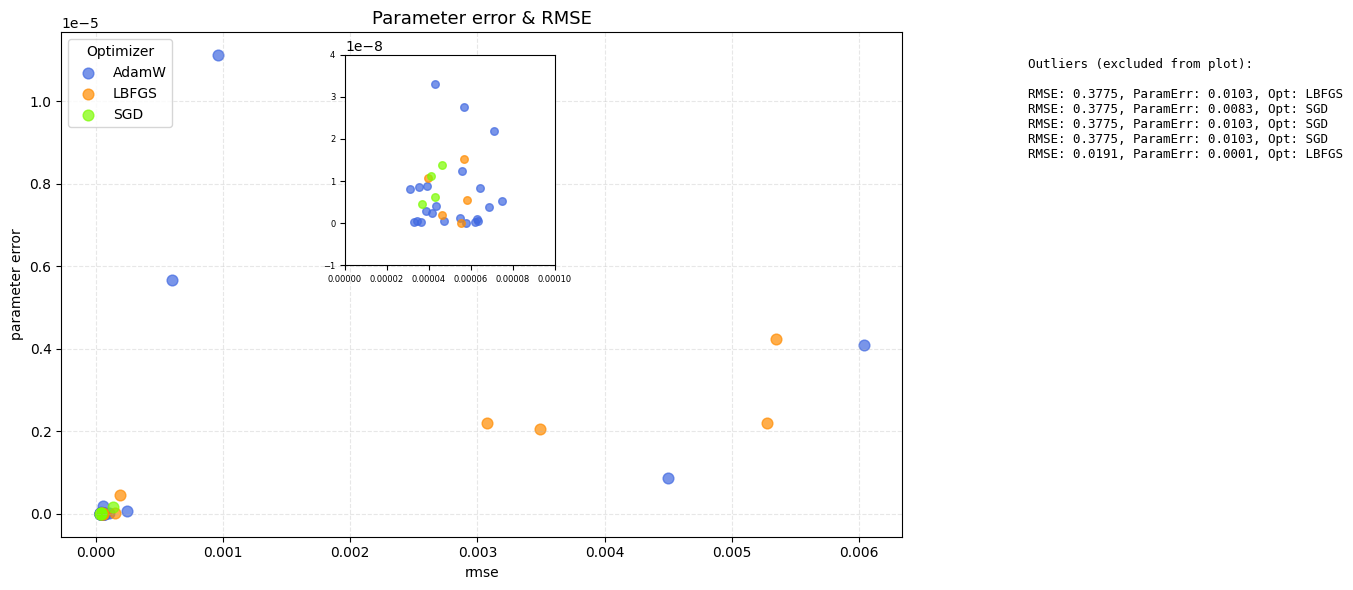

In [104]:
import pandas as pd
import matplotlib.pyplot as plt

rmse_threshold = 0.05
param_err_threshold = 0.0001

inliers = df[(df["RMSE"] <= rmse_threshold) & (df["Parameter Error"] <= param_err_threshold)]
outliers = df[(df["RMSE"] > rmse_threshold) | (df["Parameter Error"] > param_err_threshold)]

optimizer_colors = { "AdamW": "royalblue","LBFGS": "darkorange", "SGD": "lawngreen"}
fig, ax = plt.subplots(figsize=(14, 6))
for opt, color in optimizer_colors.items():
    subset = inliers[inliers["Optimizer"] == opt]
    ax.scatter(subset["RMSE"], subset["Parameter Error"],
               color=color, label=opt, s=60, alpha=0.7)

ax.set_xlabel("rmse")
ax.set_ylabel("parameter error")
ax.set_title("Parameter error & RMSE", fontsize=13)
ax.grid(True, linestyle="--", alpha=0.3)
legend = ax.legend(title="Optimizer", loc='upper left')
if not outliers.empty:
    table_text = "Outliers (excluded from plot):\n\n"
    for _, row in outliers.iterrows():
        table_text += f"RMSE: {row['RMSE']:.4f}, ParamErr: {row['Parameter Error']:.4f}, Opt: {row['Optimizer']}\n"
    ax.text(1.15, 0.95, table_text,
            transform=ax.transAxes,
            fontsize=9,
            verticalalignment='top',
            horizontalalignment='left',
            color='black',
            family='monospace')

zoom_ax = fig.add_axes([0.25, 0.55, 0.15, 0.35])  #[left, bottom, width, height]
zoom_ax.set_xlim(0, 0.0001)
zoom_ax.set_ylim(-0.00000001, 0.00000004)
for opt, color in optimizer_colors.items():
    subset = inliers[inliers["Optimizer"] == opt]
    zoom_ax.scatter(subset["RMSE"], subset["Parameter Error"],
                    color=color, s=30, alpha=0.7)
zoom_ax.tick_params(labelsize=6)

plt.tight_layout()
plt.show()
